In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import os

In [5]:
folder = 'data'
data_set = pd.DataFrame()

for activity_folder in os.listdir(folder):
    activity_path = os.path.join(folder, activity_folder)
    if not os.path.isdir(activity_path):
        continue

    for file in os.listdir(activity_path):
        file_path = os.path.join(activity_path, file)
        if not file.endswith('.csv'):
            continue
        
        df = pd.read_csv(file_path)
        df['activity'] = activity_folder
        data_set = pd.concat([data_set, df], ignore_index=True)

data_set

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,11.353305,25.656265,16.002844,running
1,14.183250,4.194642,4.912902,running
2,28.213272,30.056808,12.440272,running
3,2.341529,16.041151,-3.184288,running
4,15.744270,-12.737153,-8.954314,running
...,...,...,...,...
193855,0.277727,-0.057461,9.811439,idle
193856,0.248997,-0.033519,9.753978,idle
193857,0.225055,-0.052672,9.768343,idle
193858,0.239420,-0.052672,9.753978,idle


In [6]:
data_set.dtypes

accelerometer_X    float64
accelerometer_Y    float64
accelerometer_Z    float64
activity            object
dtype: object

In [7]:
data_set.isnull().sum()

accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
activity           0
dtype: int64

In [8]:
features = ['accelerometer_X',	'accelerometer_Y',	'accelerometer_Z']

In [9]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_set[features])

norm_data = data_set.copy()
norm_data[features] = normalized_data
norm_data

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.121943,1.928644,1.974248,running
1,1.458647,0.208137,0.432173,running
2,3.127925,2.281421,1.478867,running
3,0.049731,1.157832,-0.693754,running
4,1.644375,-1.149229,-1.496086,running
...,...,...,...,...
193855,-0.195818,-0.132740,1.113323,idle
193856,-0.199237,-0.130821,1.105333,idle
193857,-0.202085,-0.132356,1.107331,idle
193858,-0.200376,-0.132356,1.105333,idle


In [10]:
X_train, X_test, y_train, y_test = train_test_split(norm_data[features], norm_data['activity'], test_size=0.3, stratify=norm_data['activity'])

In [11]:
%%time

model_svm = SVC()
model_svm.fit(X_train, y_train)

CPU times: user 3min 4s, sys: 590 ms, total: 3min 5s
Wall time: 3min 5s


SVC()

In [12]:
%%time

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

CPU times: user 11.7 s, sys: 3.35 ms, total: 11.7 s
Wall time: 11.7 s


RandomForestClassifier()

In [13]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)

print("Точність моделі SVM:", score_svm)
print("Точність моделі Random Forest:", score_rf)

Точність моделі SVM: 0.8950961174730906
Точність моделі Random Forest: 0.9995701365246398


In [14]:
y_pred_svm = model_svm.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

In [15]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

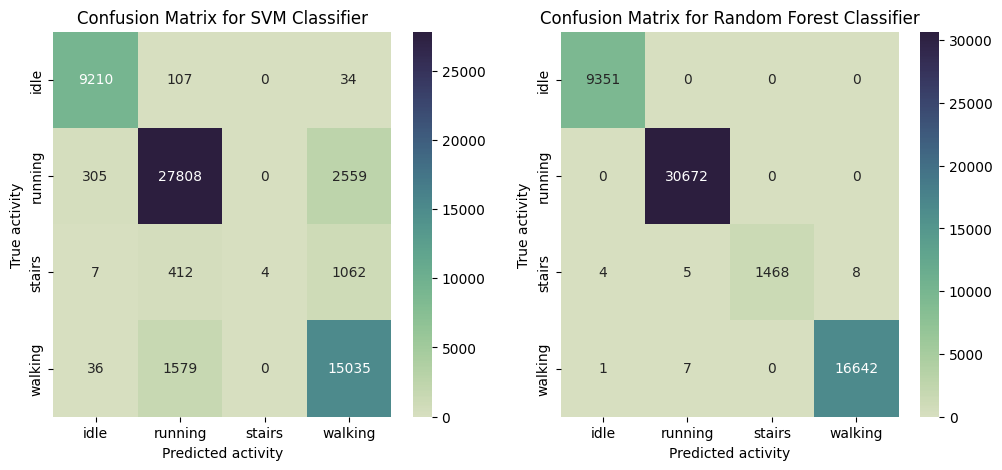

In [16]:
figure, axes = plt.subplots(1, 2, figsize=(12, 5))

classifiers = ["SVM", "Random Forest"]
confusion_matrices = [conf_matrix_svm, conf_matrix_rf]
activities = ['idle', 'running', 'stairs', 'walking']
custom_cmap = sns.color_palette("ch:s=.5,r=-.75", as_cmap=True)

for i, classifier in enumerate(classifiers):
    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        fmt='d',
        cmap=custom_cmap,
        xticklabels=activities,
        yticklabels=activities,
        ax=axes[i],
    )
  
    axes[i].set_title(f"Confusion Matrix for {classifier} Classifier")
    axes[i].set_xlabel("Predicted activity")
    axes[i].set_ylabel("True activity")

plt.show()

In [37]:
from scipy.stats import entropy, iqr, skew

def custom_entropy(data):
    # Shift the data to make all values positive
    min_val = np.min(data)
    if min_val < 0:
        data -= min_val
    
    # Add a small constant value to the shifted data to avoid log(0)
    data += 1e-9
    
    # Normalize the shifted data
    data /= np.sum(data)
    
    # Calculate entropy
    result = -np.sum(data * np.log2(data))
    
    # Check for and handle NaN or infinity values
    if np.isnan(result) or np.isinf(result):
        result = 0.0  # Set entropy to 0 in case of NaN or infinity
    
    return result



# Function to calculate the required features for X, Y, and Z axes
def calculate_features(data):
    features = {}
    
    # X axis features
    features['max_x'] = data['accelerometer_X'].max()
    features['min_x'] = data['accelerometer_X'].min()
    features['entropy_x'] = custom_entropy(data['accelerometer_X'])
    features['iqr_x'] = iqr(data['accelerometer_X'])
    
    # Y axis features
    features['max_y'] = data['accelerometer_Y'].max()
    features['min_y_idx'] = data['accelerometer_Y'].idxmin()
    features['mean_abs_dev_y'] = np.mean(np.abs(data['accelerometer_Y'] - data['accelerometer_Y'].mean()))
    features['median_y'] = data['accelerometer_Y'].median()
    features['skew_y'] = skew(data['accelerometer_Y'])
    features['std_y'] = data['accelerometer_Y'].std()
    features['rmse_y'] = np.sqrt(np.mean(data['accelerometer_Y'] ** 2))
    
    # Z axis features
    features['skew_z'] = skew(data['accelerometer_Z'])
    
    return features

# List to accumulate all feature dictionaries
all_features = []

# Iterate through each activity and process the files
for activity in os.listdir(folder):
    activity_folder = os.path.join(folder, activity)
    if not os.path.isdir(activity_folder):
        continue
    
    for file in os.listdir(activity_folder):
        file_path = os.path.join(activity_folder, file)
        if not file.endswith('.csv'):
            continue
        
        # Read the file into a pandas DataFrame
        file_data = pd.read_csv(file_path)
        
        # Calculate features
        features = calculate_features(file_data)
        features['activity'] = activity
        
        # Append the features dictionary to the list
        all_features.append(features)

# Convert the list of feature dictionaries to a DataFrame
enhanced_data = pd.DataFrame(all_features)

enhanced_data.head()

,max_x,min_x,entropy_x,iqr_x,max_y,min_y_idx,mean_abs_dev_y,median_y,skew_y,std_y,rmse_y,skew_z,activity
0,34.495660,-6.885724,4.483190,0.036339,39.188293,15,13.258280,6.933608,0.373574,16.080620,18.576968,0.471638,running
1,28.625076,-6.995857,4.424778,0.037554,26.561274,27,7.372737,7.280767,-0.069999,9.343366,12.051590,0.848387,running
2,27.087997,-5.712565,4.585985,0.026788,29.836542,25,10.649005,11.075577,-0.112862,12.429791,15.572947,0.459290,running
3,22.792800,-4.084508,4.588912,0.027711,29.338547,26,8.051541,7.321469,0.258173,10.251043,12.270425,0.328316,running
4,32.953793,-3.045424,4.350846,0.028923,23.520638,4,6.084890,6.878541,0.145624,7.706611,9.410074,0.325423,running


In [42]:
enhanced_features = enhanced_data.drop('activity', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    enhanced_features,
    enhanced_data['activity'],
    test_size=0.3, 
    stratify=enhanced_data['activity']
)

In [43]:
%%time

model_svm = SVC()
model_svm.fit(X_train, y_train)

CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 111 ms


SVC()

In [44]:
%%time

model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

CPU times: user 764 ms, sys: 9.5 ms, total: 774 ms
Wall time: 781 ms


RandomForestClassifier()

In [45]:
score_svm = model_svm.score(X_test, y_test)
score_rf = model_rf.score(X_test, y_test)

print("Точність моделі SVM:", score_svm)
print("Точність моделі Random Forest:", score_rf)

Точність моделі SVM: 0.9747292418772563
Точність моделі Random Forest: 0.997421351211965


In [46]:
y_pred_svm = model_svm.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

In [47]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

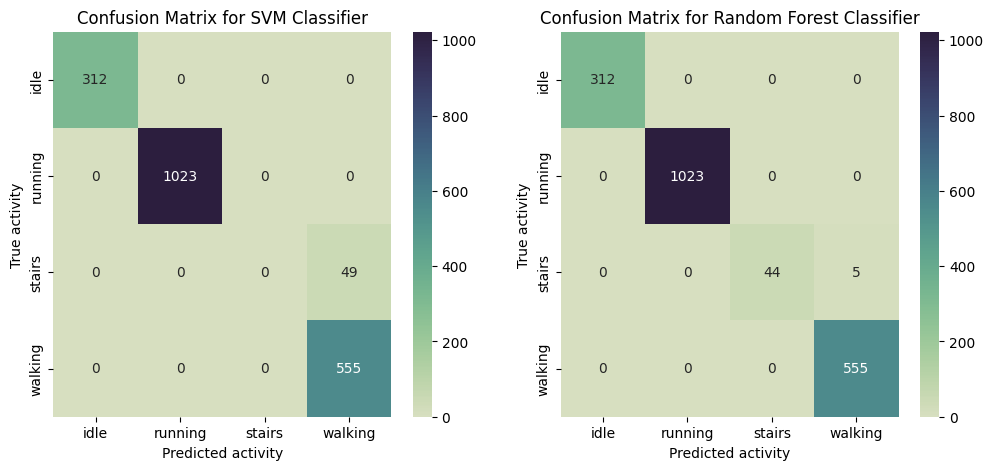

In [48]:
figure, axes = plt.subplots(1, 2, figsize=(12, 5))

classifiers = ["SVM", "Random Forest"]
confusion_matrices = [conf_matrix_svm, conf_matrix_rf]
activities = ['idle', 'running', 'stairs', 'walking']
custom_cmap = sns.color_palette("ch:s=.5,r=-.75", as_cmap=True)

for i, classifier in enumerate(classifiers):
    sns.heatmap(
        confusion_matrices[i],
        annot=True,
        fmt='d',
        cmap=custom_cmap,
        xticklabels=activities,
        yticklabels=activities,
        ax=axes[i],
    )
  
    axes[i].set_title(f"Confusion Matrix for {classifier} Classifier")
    axes[i].set_xlabel("Predicted activity")
    axes[i].set_ylabel("True activity")

plt.show()